In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

Precision: 1.0000

Confusion Matrix:
[[42  0  0]
 [ 0 49  0]
 [ 0  0 59]]


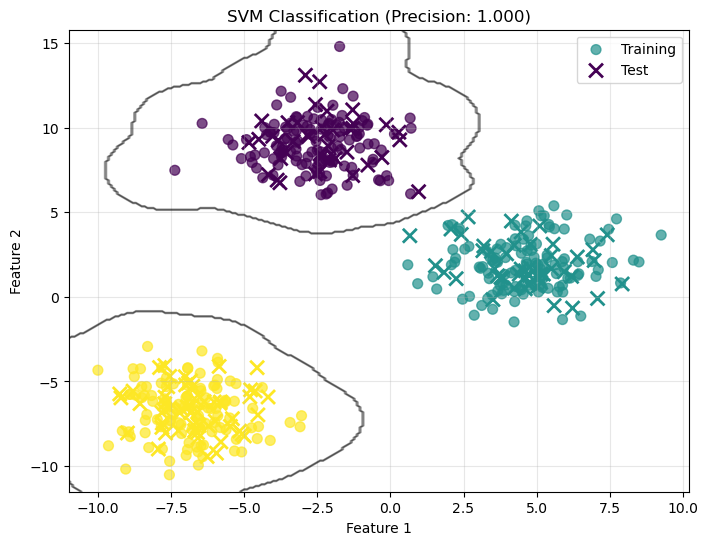

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix

def simple_svm_demo():
    """
    Simple introduction to SVM with 3-class classification
    """
    # Generate synthetic data with 3 classes
    X, y = make_blobs(n_samples=500, centers=3, n_features=2, 
                      cluster_std=1.5, random_state=42)
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    
    # Create and train SVM classifier
    clf = svm.SVC(kernel='rbf', gamma=0.7, C=1.0, decision_function_shape='ovr')
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred, average='macro')
    
    # Print results
    print(f"Precision: {precision:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Simple plotting
    plt.figure(figsize=(8, 6))
    
    # Plot training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                cmap='viridis', s=50, alpha=0.7, label='Training')
    
    # Plot test points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', 
                marker='x', s=100, linewidth=2, label='Test')
    
    # Add decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='black', linewidths=1, alpha=0.3)
    
    plt.title(f"SVM Classification (Precision: {precision:.3f})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    simple_svm_demo()

In [23]:
import numpy as np
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
import warnings

class SVMPlus(BaseEstimator, ClassifierMixin):
    """
    SVM+ (Support Vector Machine with Privileged Information) implementation
    
    This implementation follows the formulation from Vapnik's paper:
    "Learning Using Privileged Information: Similarity Control and Knowledge Transfer"
    """
    
    def __init__(self, C=1.0, gamma=1.0, kernel='rbf', kernel_star='rbf', 
                 kernel_params=None, kernel_star_params=None, tol=1e-6, max_iter=1000):
        """
        Initialize SVM+ classifier
        
        Parameters:
        -----------
        C : float, default=1.0
            Regularization parameter
        gamma : float, default=1.0
            Regularization parameter for privileged information
        kernel : str or callable, default='rbf'
            Kernel function for regular features
        kernel_star : str or callable, default='rbf'
            Kernel function for privileged features
        kernel_params : dict, default=None
            Parameters for regular kernel
        kernel_star_params : dict, default=None
            Parameters for privileged kernel
        tol : float, default=1e-6
            Tolerance for optimization
        max_iter : int, default=1000
            Maximum iterations for optimization
        """
        self.C = C
        self.gamma = gamma
        self.kernel = kernel
        self.kernel_star = kernel_star
        self.kernel_params = kernel_params or {}
        self.kernel_star_params = kernel_star_params or {}
        self.tol = tol
        self.max_iter = max_iter
        
    def _get_kernel_function(self, kernel_type, params):
        """Get kernel function based on type and parameters"""
        if kernel_type == 'linear':
            return lambda X, Y: linear_kernel(X, Y, **params)
        elif kernel_type == 'rbf':
            return lambda X, Y: rbf_kernel(X, Y, **params)
        elif kernel_type == 'poly':
            return lambda X, Y: polynomial_kernel(X, Y, **params)
        elif callable(kernel_type):
            return kernel_type
        else:
            raise ValueError(f"Unknown kernel type: {kernel_type}")
    
    def _compute_kernel_matrix(self, X, Y, kernel_func):
        """Compute kernel matrix between X and Y"""
        return kernel_func(X, Y)
    
    def fit(self, X, X_star, y):
        """
        Fit SVM+ model
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Regular training features
        X_star : array-like, shape (n_samples, n_privileged_features)
            Privileged training features
        y : array-like, shape (n_samples,)
            Target values (-1 or 1)
        """
        X = np.array(X)
        X_star = np.array(X_star)
        y = np.array(y)
        
        # Ensure y is in {-1, 1}
        unique_y = np.unique(y)
        if set(unique_y) != {-1, 1}:
            # Convert to {-1, 1} if needed
            y_binary = np.where(y == unique_y[0], -1, 1)
            self.classes_ = unique_y
            y = y_binary
        else:
            self.classes_ = np.array([-1, 1])
        
        self.n_samples_ = X.shape[0]
        self.X_train_ = X
        self.X_star_train_ = X_star
        self.y_train_ = y
        
        # Get kernel functions
        self.kernel_func_ = self._get_kernel_function(self.kernel, self.kernel_params)
        self.kernel_star_func_ = self._get_kernel_function(self.kernel_star, self.kernel_star_params)
        
        # Compute kernel matrices
        self.K_ = self._compute_kernel_matrix(X, X, self.kernel_func_)
        self.K_star_ = self._compute_kernel_matrix(X_star, X_star, self.kernel_star_func_)
        
        # Solve dual optimization problem
        self._solve_dual()
        
        # Compute bias terms
        self._compute_bias()
        
        return self
    
    def _solve_dual(self):
        """Solve the dual optimization problem"""
        n = self.n_samples_
        
        # Initial guess for alpha and beta
        x0 = np.zeros(2 * n)
        
        # Bounds: alpha_i >= 0, 0 <= beta_i <= C
        bounds = [(0, None) for _ in range(n)] + [(0, self.C) for _ in range(n)]
        
        # Constraints
        constraints = [
            # Sum(alpha_i * y_i) = 0
            {
                'type': 'eq',
                'fun': lambda x: np.sum(x[:n] * self.y_train_),
                'jac': lambda x: np.concatenate([self.y_train_, np.zeros(n)])
            },
            # Sum(alpha_i - beta_i) = 0
            {
                'type': 'eq',
                'fun': lambda x: np.sum(x[:n] - x[n:]),
                'jac': lambda x: np.concatenate([np.ones(n), -np.ones(n)])
            }
        ]
        
        # Solve optimization problem
        result = minimize(
            fun=self._dual_objective,
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': self.max_iter, 'ftol': self.tol}
        )
        
        if not result.success:
            warnings.warn(f"Optimization did not converge: {result.message}")
        
        # Extract alpha and beta
        self.alpha_ = result.x[:n]
        self.beta_ = result.x[n:]
        
        # Find support vectors
        self.support_mask_ = self.alpha_ > self.tol
        self.support_ = np.where(self.support_mask_)[0]
        self.n_support_ = len(self.support_)
        
    def _dual_objective(self, x):
        """Dual objective function to minimize (negative of the original maximization)"""
        n = self.n_samples_
        alpha = x[:n]
        beta = x[n:]
        
        # First term: -sum(alpha_i)
        term1 = -np.sum(alpha)
        
        # Second term: 1/2 * sum_ij(alpha_i * alpha_j * y_i * y_j * K(x_i, x_j))
        term2 = 0.5 * np.sum(alpha[:, np.newaxis] * alpha[np.newaxis, :] * 
                            self.y_train_[:, np.newaxis] * self.y_train_[np.newaxis, :] * 
                            self.K_)
        
        # Third term: 1/(2*gamma) * sum_ij((alpha_i - beta_i) * (alpha_j - beta_j) * K*(x*_i, x*_j))
        alpha_minus_beta = alpha - beta
        term3 = (1.0 / (2.0 * self.gamma)) * np.sum(
            alpha_minus_beta[:, np.newaxis] * alpha_minus_beta[np.newaxis, :] * self.K_star_)
        
        return term1 + term2 + term3
    
    def _compute_bias(self):
        """Compute bias terms b and b*"""
        if self.n_support_ == 0:
            self.b_ = 0.0
            self.b_star_ = 0.0
            return
        
        # For support vectors with 0 < alpha_i < C, we can compute b
        # yi * (sum(alpha_j * yj * K(xi, xj)) + b) = 1 - (w*, z*i) - b*
        
        # Find support vectors that are not on the boundary
        free_sv_mask = (self.alpha_ > self.tol) & (self.alpha_ < self.C - self.tol)
        free_sv_indices = np.where(free_sv_mask)[0]
        
        if len(free_sv_indices) > 0:
            # Use the first free support vector to compute b
            i = free_sv_indices[0]
            
            # Compute decision function without bias
            decision_no_bias = np.sum(self.alpha_ * self.y_train_ * self.K_[i, :])
            
            # Compute privileged part
            privileged_part = np.sum((self.alpha_ - self.beta_) * self.K_star_[i, :]) / self.gamma
            
            # b = yi * (1 - privileged_part) - decision_no_bias
            self.b_ = self.y_train_[i] * (1.0 - privileged_part) - decision_no_bias
            
            # For b*, we use the relation: xi = (w*, z*i) + b*
            # From the slack function definition
            self.b_star_ = privileged_part - np.sum((self.alpha_ - self.beta_) * self.K_star_[i, :]) / self.gamma
        else:
            # Fallback: use average over all support vectors
            self.b_ = 0.0
            self.b_star_ = 0.0
    
    def decision_function(self, X):
        """
        Compute the decision function for samples in X
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        decision : array, shape (n_samples,)
            Decision function values
        """
        X = np.array(X)
        
        # Compute kernel between test and training samples
        K_test = self._compute_kernel_matrix(X, self.X_train_, self.kernel_func_)
        
        # Decision function: sum(alpha_i * y_i * K(x, x_i)) + b
        # K_test shape: (n_test_samples, n_train_samples)
        # alpha_ and y_train_ shape: (n_train_samples,)
        # We need to compute: K_test @ (alpha_ * y_train_)
        decision = K_test @ (self.alpha_ * self.y_train_) + self.b_
        
        return decision
    
    def predict(self, X):
        """
        Predict class labels for samples in X
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Predicted class labels
        """
        decision = self.decision_function(X)
        predictions = np.sign(decision)
        
        # Convert back to original class labels if needed
        if hasattr(self, 'classes_') and len(self.classes_) == 2:
            predictions = np.where(predictions == -1, self.classes_[0], self.classes_[1])
        
        return predictions
    
    def get_params(self, deep=True):
        """Get parameters for this estimator"""
        return {
            'C': self.C,
            'gamma': self.gamma,
            'kernel': self.kernel,
            'kernel_star': self.kernel_star,
            'kernel_params': self.kernel_params,
            'kernel_star_params': self.kernel_star_params,
            'tol': self.tol,
            'max_iter': self.max_iter
        }
    
    def set_params(self, **params):
        """Set parameters for this estimator"""
        for param, value in params.items():
            setattr(self, param, value)
        return self


# Example usage and testing
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(42)
    n_samples = 100
    n_features = 2
    n_privileged = 3
    
    # Generate regular features
    X = np.random.randn(n_samples, n_features)
    
    # Generate privileged features (correlated with the target)
    X_star = np.random.randn(n_samples, n_privileged)
    
    # Generate target (binary classification)
    y = np.sign(X[:, 0] + X[:, 1] + 0.5 * np.sum(X_star, axis=1) + 0.1 * np.random.randn(n_samples))
    
    # Split data
    train_size = int(0.7 * n_samples)
    X_train, X_test = X[:train_size], X[train_size:]
    X_star_train = X_star[:train_size]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Train SVM+
    svm_plus = SVMPlus(C=1.0, gamma=0.1, kernel='rbf', kernel_star='rbf')
    svm_plus.fit(X_train, X_star_train, y_train)
    
    # Make predictions
    y_pred = svm_plus.predict(X_test)
    
    # Compute accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f"SVM+ Accuracy: {accuracy:.3f}")
    print(f"Number of support vectors: {svm_plus.n_support_}")
    
    # Compare with standard SVM (sklearn)
    from sklearn.svm import SVC
    svm_standard = SVC(kernel='rbf', C=1.0)
    svm_standard.fit(X_train, y_train)
    y_pred_standard = svm_standard.predict(X_test)
    accuracy_standard = np.mean(y_pred_standard == y_test)
    print(f"Standard SVM Accuracy: {accuracy_standard:.3f}")
    print(f"Standard SVM Support Vectors: {len(svm_standard.support_)}")

SVM+ Accuracy: 0.767
Number of support vectors: 35
Standard SVM Accuracy: 0.867
Standard SVM Support Vectors: 39


Dataset: moons
SVM+ accuracy: 0.900
Standard SVM accuracy: 0.933


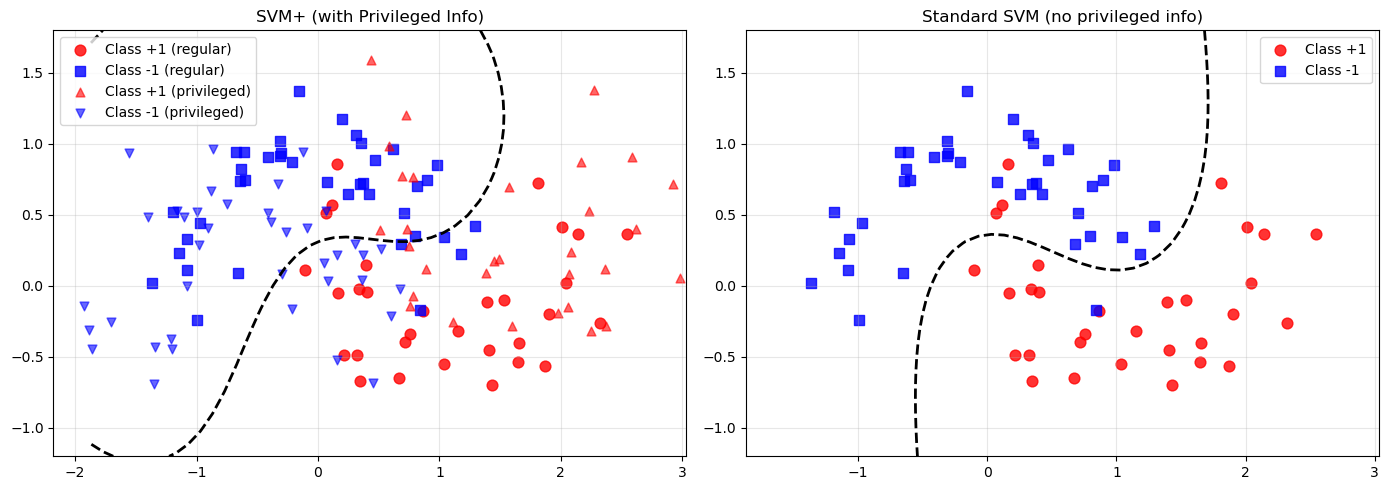

Dataset: circles
SVM+ accuracy: 0.667
Standard SVM accuracy: 0.867


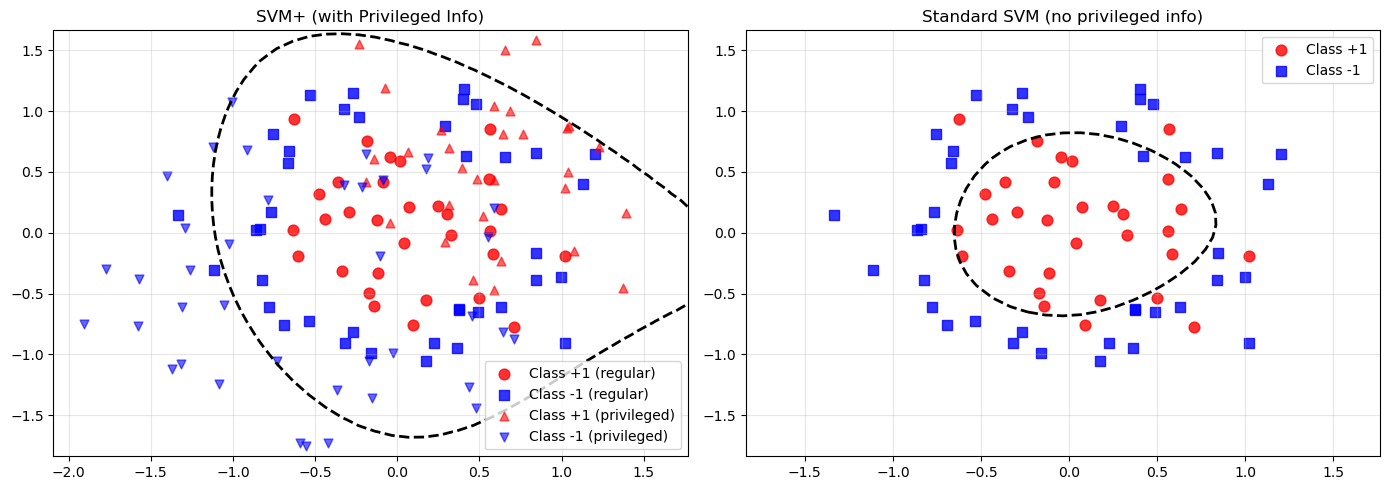

Dataset: blobs
SVM+ accuracy: 1.000
Standard SVM accuracy: 1.000


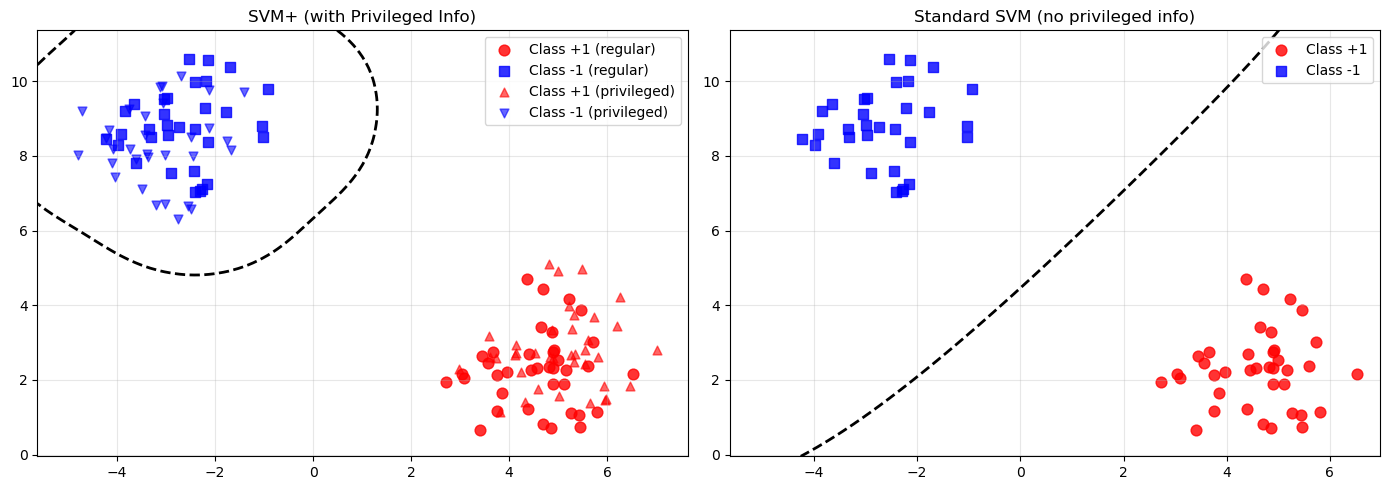

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles, make_blobs

# Import the SVMPlus class (assuming it's in the same file or imported)
# from svmplus import SVMPlus

def plot_svm_comparison(dataset='moons'):
    """
    Simple comparison of SVM+ vs standard SVM using toy datasets
    """
    np.random.seed(42)
    
    # Generate toy dataset
    if dataset == 'moons':
        X, y = make_moons(n_samples=100, noise=0.2, random_state=42)
    elif dataset == 'circles':
        X, y = make_circles(n_samples=100, noise=0.2, factor=0.5, random_state=42)
    elif dataset == 'blobs':
        X, y = make_blobs(n_samples=100, centers=2, random_state=42)
    
    # Convert labels to {-1, 1}
    y = np.where(y == 0, -1, 1)
    
    # Create simple privileged features (helpful additional info)
    # Make them correlated with the target to simulate useful privileged info
    X_star = np.column_stack([
        X[:, 0] + 0.5 * y + 0.2 * np.random.randn(len(X)),
        X[:, 1] + 0.5 * y + 0.2 * np.random.randn(len(X))
    ])
    
    # Simple train/test split
    train_size = 70
    X_train, X_test = X[:train_size], X[train_size:]
    X_star_train = X_star[:train_size]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Train models
    svm_plus = SVMPlus(C=1.0, gamma=0.5, kernel='rbf', kernel_star='rbf')
    svm_plus.fit(X_train, X_star_train, y_train)
    
    svm_standard = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_standard.fit(X_train, y_train)
    
    # Simple plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot SVM+
    ax1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='red', marker='o', s=60, label='Class +1 (regular)', alpha=0.8)
    ax1.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], 
                c='blue', marker='s', s=60, label='Class -1 (regular)', alpha=0.8)
    
    # Plot privileged information points
    ax1.scatter(X_star_train[y_train == 1, 0], X_star_train[y_train == 1, 1], 
                c='red', marker='^', s=40, label='Class +1 (privileged)', alpha=0.6)
    ax1.scatter(X_star_train[y_train == -1, 0], X_star_train[y_train == -1, 1], 
                c='blue', marker='v', s=40, label='Class -1 (privileged)', alpha=0.6)
    
    # Add decision boundary
    h = 0.1
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm_plus.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax1.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2, linestyles='--')
    
    ax1.set_title('SVM+ (with Privileged Info)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Standard SVM
    ax2.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='red', marker='o', s=60, label='Class +1', alpha=0.8)
    ax2.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], 
                c='blue', marker='s', s=60, label='Class -1', alpha=0.8)
    
    Z = svm_standard.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax2.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2, linestyles='--')
    
    ax2.set_title('Standard SVM (no privileged info)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print simple results
    y_pred_plus = svm_plus.predict(X_test)
    y_pred_standard = svm_standard.predict(X_test)
    
    print(f"Dataset: {dataset}")
    print(f"SVM+ accuracy: {np.mean(y_pred_plus == y_test):.3f}")
    print(f"Standard SVM accuracy: {np.mean(y_pred_standard == y_test):.3f}")
    
    plt.show()
    return fig

# Test different datasets
if __name__ == "__main__":
    for dataset in ['moons', 'circles', 'blobs']:
        plot_svm_comparison(dataset)